In [1]:
import os
import sys
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

np.random.seed(1234)

import logging
logger = logging.getLogger('pystan')
logger.addHandler(logging.NullHandler())

import pystan
import scipy.stats as stats
import arviz

%matplotlib inline
%precision 4
plt.style.use('ggplot')

# This library is needed for building Stan files in notebooks
import nest_asyncio
nest_asyncio.apply()

# This library is needed for multichain MCMC
import multiprocessing
multiprocessing.set_start_method("fork")

# Example 1: Coin-toss

In [2]:
n = 200    # Number of tosses
x = 80     # Number of heads
a = 20     # Parameter "a" of the prior (Beta Distribution)
b = 20     # Parameter "b" of the prior (Beta Distribution)

## Analytical Bayes

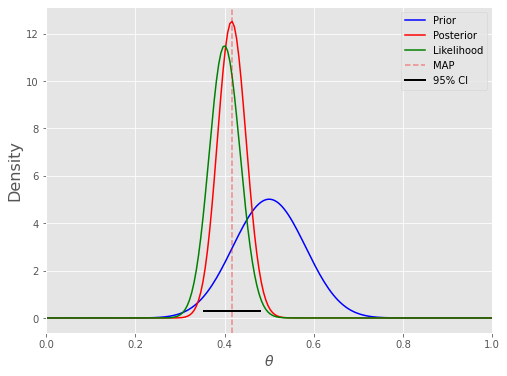

In [16]:
prior = stats.beta(a, b)
post = stats.beta(a+x, b+n-x)
ci = post.interval(0.95)

thetas = np.linspace(0, 1, 200)
plt.figure(figsize=(8, 6))
plt.plot(thetas, prior.pdf(thetas), label='Prior', c='blue')
plt.plot(thetas, post.pdf(thetas), label='Posterior', c='red')
plt.plot(thetas, n*stats.binom(n, thetas).pmf(x), label='Likelihood', c='green')
plt.axvline((x+a-1)/(n+a+b-2), c='red', linestyle='dashed', alpha=0.4, label='MAP')
# plt.axvline(mu/n, c='green', linestyle='dashed', alpha=0.4, label='MLE')
plt.xlim([0, 1])
plt.axhline(0.3, ci[0], ci[1], c='black', linewidth=2, label='95% CI');
plt.xlabel(r'$\theta$', fontsize=14)
plt.ylabel('Density', fontsize=16)
plt.legend()
plt.show()

In [18]:
print("MAP:", (x+a-1)/(n+a+b-2))
print("95% CI:", ci)

MAP: 0.41596638655462187
95% CI: (0.35513893178835043, 0.479510148532563)


## Approximated Bayes by MCMC

In [4]:
data_coin_toss = {
    "n": n,
    "x": x,
    "a": a,
    "b": b
}

In [5]:
stan_coin_toss = """
data {
    int<lower=0> n; // Number of tosses
    int<lower=0> x; // Number of heads
    int<lower=0> a; // Parameter "a" of the prior (Beta Distribution)
    int<lower=0> b; // Parameter "b" of the prior (Beta Distribution)
}

parameters {
    real<lower=0, upper=1> p;
}

model {
    p ~ beta(a, b); // Write a prior distribution
    x ~ binomial(n, p);
}
"""

In [6]:
sm = pystan.StanModel(model_code=stan_coin_toss)

In [ ]:
sample_kwargs = {"iter": 1000, "chains": 4, "warmup": 100}
fit = sm.sampling(data=data_coin_toss, **sample_kwargs)

In [56]:
print(fit)

Inference for Stan model: anon_model_00e638cfaf824d769a7edda3c365549d.
4 chains, each with iter=1000; warmup=100; thin=1; 
post-warmup draws per chain=900, total post-warmup draws=3600.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
p      0.42  8.5e-4   0.03   0.35   0.39   0.42   0.44   0.48   1374    1.0
lp__ -163.5    0.02   0.69 -165.4 -163.6 -163.2 -163.0 -163.0   1805    1.0

Samples were drawn using NUTS at Mon May 30 13:51:39 2022.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


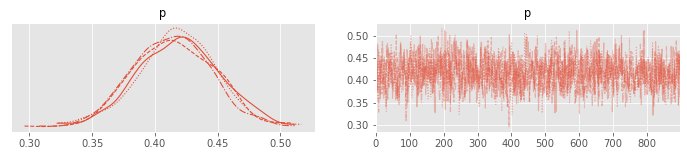

In [57]:
arviz.plot_trace(fit, var_names=('p'), combined=False);

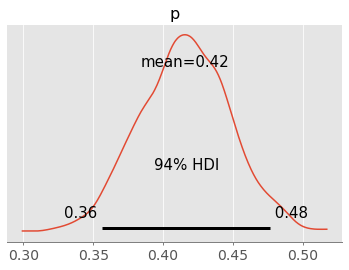

In [45]:
arviz.plot_posterior(fit, var_names=['p']);

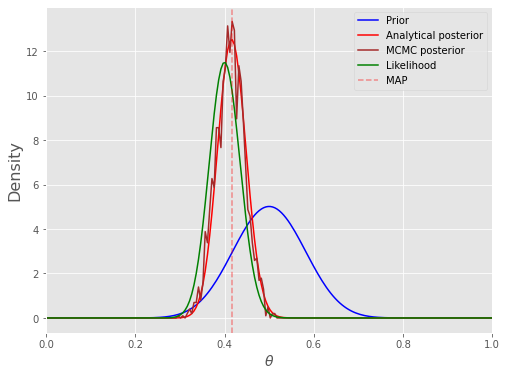

In [43]:
thetas = np.linspace(0, 1, 200)
post_hist = np.histogram(fit.extract()["p"], bins=thetas)
post_dist = stats.rv_histogram(post_hist)

plt.figure(figsize=(8, 6))
plt.plot(thetas, prior.pdf(thetas), label='Prior', c='blue')
plt.plot(thetas, post.pdf(thetas), label='Analytical posterior', c='red')
plt.plot(thetas, post_dist.pdf(thetas), label='MCMC posterior', c='brown')
plt.plot(thetas, n*stats.binom(n, thetas).pmf(x), label='Likelihood', c='green')
plt.axvline((x+a-1)/(n+a+b-2), c='red', linestyle='dashed', alpha=0.4, label='MAP')
# plt.axvline(mu/n, c='green', linestyle='dashed', alpha=0.4, label='MLE')
plt.xlim([0, 1])
plt.xlabel(r'$\theta$', fontsize=14)
plt.ylabel('Density', fontsize=16)
plt.legend()
plt.show()

## Example of poor convergence

In [81]:
sample_kwargs = {"iter": 20, "chains": 4, "warmup": 10}
fit = sm.sampling(data=data_coin_toss, **sample_kwargs)


Gradient evaluation took 3.4e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.34 seconds.
Adjust your expectations accordingly!


         performed for num_warmup < 20

Iteration:  1 / 20 [  5%]  (Warmup)
Iteration:  2 / 20 [ 10%]  (Warmup)
Iteration:  4 / 20 [ 20%]  (Warmup)

Iteration:  6 / 20 [ 30%]  (Warmup)
Gradient evaluation took 3.7e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.37 seconds.
Adjust your expectations accordingly!


Iteration:  8 / 20 [ 40%]  (Warmup)
         performed for num_warmup < 20

Iteration: 10 / 20 [ 50%]  (Warmup)
Iteration: 11 / 20 [ 55%]  (Sampling)
Iteration: 12 / 20 [ 60%]  (Sampling)
Iteration:  1 / 20 [  5%]  (Warmup)
Iteration: 14 / 20 [ 70%]  (Sampling)
Iteration:  2 / 20 [ 10%]  (Warmup)
Iteration:  4 / 20 [ 20%]  (Warmup)
Iteration:  6 / 20 [ 30%]  (Warmup)
Iteration: 16 / 20 [ 80%]  (Sampling)
Iteration:  8 / 20 [ 40%]  (Warmup)
Iteration: 10 / 20 [ 50%]  (Warmup)
Iteration:

In [82]:
print(fit)

Inference for Stan model: anon_model_00e638cfaf824d769a7edda3c365549d.
4 chains, each with iter=20; warmup=10; thin=1; 
post-warmup draws per chain=10, total post-warmup draws=40.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
p      0.41  5.0e-3   0.02   0.35    0.4   0.41   0.42   0.46     24   1.16
lp__ -163.3    0.12   0.61 -165.5 -163.3 -163.0 -163.0 -163.0     25   1.07

Samples were drawn using NUTS at Mon May 30 13:55:43 2022.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


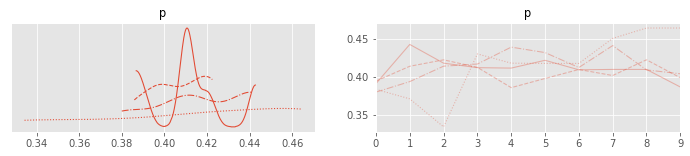

In [83]:
arviz.plot_trace(fit, var_names=('p'), combined=False);

# Example 2: Linear regression

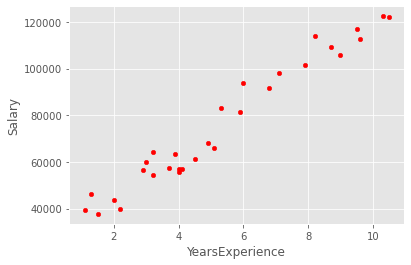

In [250]:
df = pd.read_csv("./data/Salary_Data.csv")
xs = np.array(df["YearsExperience"])
ts = np.array(df["Salary"])

df.plot.scatter(x="YearsExperience", y= "Salary", c="r");

In [187]:
data_lin_reg = {
    "N": len(np.array(df["YearsExperience"])),
    "x": np.array(df["YearsExperience"]),
    "t": np.array(df["Salary"])
}

In [188]:
stan_lin_reg = """
data {
  int<lower=0> N;
  vector[N] x;
  vector[N] t;
}

parameters {
  real beta_0;
  real beta_1;
  real<lower=0> sigma;
}

model {
  t ~ normal(beta_0 + beta_1 * x, sigma);
}
"""

In [ ]:
sm = pystan.StanModel(model_code=stan_lin_reg)

In [ ]:
sample_kwargs = {"iter": 5000, "chains": 4, "warmup": 1000}
fit = sm.sampling(data=data_lin_reg, **sample_kwargs)

In [212]:
print(fit)

Inference for Stan model: anon_model_3ed5c26936f67907e4f67b5f2ab185e0.
4 chains, each with iter=5000; warmup=1000; thin=1; 
post-warmup draws per chain=4000, total post-warmup draws=16000.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta_0  2.6e4   30.01 2407.6  2.1e4  2.4e4  2.6e4  2.7e4  3.1e4   6438    1.0
beta_1 9448.7    4.99 399.19 8666.2 9186.6 9449.6 9711.3  1.0e4   6404    1.0
sigma  6072.9    9.88 854.03 4687.2 5462.2 5970.8 6580.7 8020.8   7467    1.0
lp__   -266.8    0.02   1.29 -270.1 -267.3 -266.4 -265.8 -265.3   5230    1.0

Samples were drawn using NUTS at Tue May 31 00:21:57 2022.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


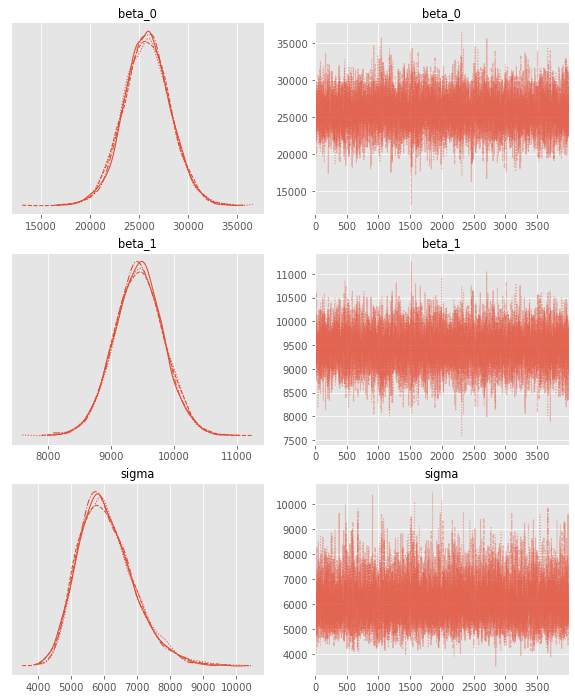

In [217]:
arviz.plot_trace(fit, var_names=('beta_0', 'beta_1', 'sigma'), figsize=(10, 12));

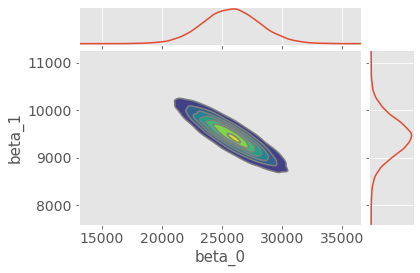

In [223]:
arviz.plot_pair(
    fit,
    var_names=['beta_0', 'beta_1'],
    kind="kde",
    marginals=True
)
plt.show()

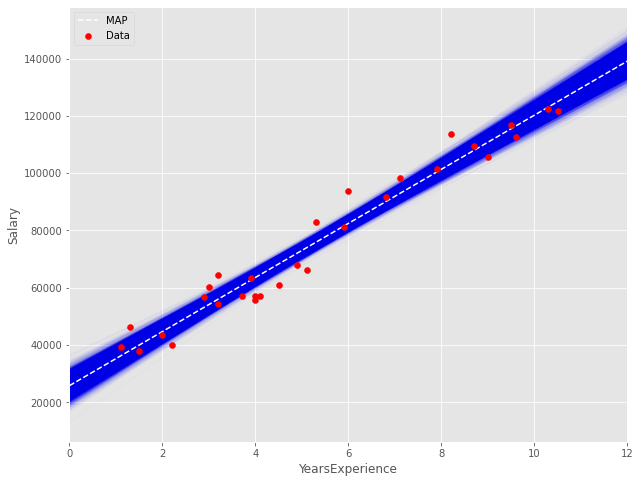

In [249]:
plt.figure(figsize=(10, 8))
for row in range(0, len(fit.extract()["beta_0"])):
    fit_line = np.poly1d([fit.extract()["beta_1"][row], fit.extract()["beta_0"][row]])
    x = np.arange(13)
    y = fit_line(x)
    plt.plot(x, y, "b-", alpha=0.01, zorder=1)
fit_line = np.poly1d([fit.get_posterior_mean()[1].mean(), fit.get_posterior_mean()[0].mean()])
x = np.arange(13)
y = fit_line(x)
plt.plot(x, y, "w--", alpha=1., zorder=1, label="MAP")
plt.scatter(df["YearsExperience"], df["Salary"], c="r", zorder=2, label="Data")
plt.xlim([0, 12])
plt.ylabel("Salary")
plt.xlabel("YearsExperience")
plt.legend()
plt.show()